## Finetune GIT on a subset of MSCOCO

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset,DataLoader
from pycocotools.coco import COCO
from transformers import AutoProcessor, AutoModelForCausalLM, AutoConfig
from tqdm import tqdm
from dataset import ImageCaptionDataset
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )


In [13]:
model_path = "microsoft/git-base"
# model_path = "Salesforce/blip2-opt-2.7b"
        
        

In [14]:
# 测试
processor = AutoProcessor.from_pretrained(model_path)
train_dataset = ImageCaptionDataset(processor=processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
print(len(train_dataset))
item = train_dataset[0]
for k,v in item.items():
    if k != 'img_id':
        print(k,v.shape)
    else:
        print(k,v)

loading annotations into memory...
Done (t=1.35s)
creating index...
index created!
70194
input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])
img_id 9


In [15]:
# 测试 验证集
# 测试
processor = AutoProcessor.from_pretrained(model_path)
val_dataset = ImageCaptionDataset(processor=processor,mode = 'val')
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=16)
print(len(val_dataset))
item = val_dataset[0]
for k,v in item.items():
    if k != 'img_id':
        print(k,v.shape)
    else:
        print(k,v)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
20252
input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])
img_id 74


In [16]:
# 测试
batch = next(iter(val_dataloader))
for k,v in batch.items():
    if k != 'img_id':
        print(k,v.shape)
    else:
        print(k,v)


input_ids torch.Size([16, 512])
attention_mask torch.Size([16, 512])
pixel_values torch.Size([16, 3, 224, 224])
img_id tensor([ 74, 133, 139, 143, 192, 208, 241, 257, 283, 285, 357, 359, 360, 387,
        415, 428])


In [18]:
# 测试
processor.decode(batch["input_ids"][0])

'[CLS] dog snoozing by a bike on the edge of a cobblestone street [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

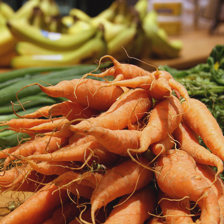

In [25]:
# 测试
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [19]:

config = AutoConfig.from_pretrained('microsoft/git-base') 
model = AutoModelForCausalLM.from_pretrained('microsoft/git-base', config=config)
model = AutoModelForCausalLM.from_pretrained(model_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [13]:

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value",'q_proj','v_proj'],
    lora_dropout=0.1,
    bias="none",
    # modules_to_save=["output"], 这样做总是把所有层都冻结
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 884736 || all params: 177503802 || trainable%: 0.50


In [14]:
for name, param in  model.named_parameters():
    if name.startswith('output.'):
        param.requires_grad = True

In [ ]:
# 测试
print(batch['pixel_values'].shape)
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
print('init loss',outputs.loss)
print(outputs.logits.shape)
print(batch['input_ids'].shape)

In [ ]:
generated_ids = torch.argmax(outputs.logits, dim=-1)
print(generated_ids[0])

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda:3" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in tqdm(range(2)):
  print("Epoch:", epoch)
  for idx, batch in tqdm(enumerate(train_dataloader)):
    input_ids = batch["input_ids"].to(device)
    pixel_values = batch["pixel_values"].to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

### Inference

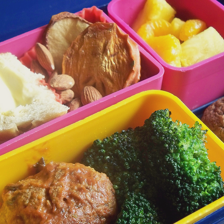

In [69]:
example = train_dataset[0]
# 测试
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255
unnormalized_image = (example["pixel_values"].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [21]:
example = next(iter(val_dataloader))

print(example['pixel_values'].shape)

torch.Size([16, 3, 224, 224])


In [23]:
# example = next(iter(train_dataloader))

# print(example['pixel_values'].shape)

torch.Size([16, 3, 224, 224])


In [23]:
# prepare image for the model
device = 'cuda:0'
model.to(device)
pixel_values = example["pixel_values"].to(device)
print(pixel_values.shape)
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
print(generated_ids.shape)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(generated_caption)
print(example['img_id'])
# ground truth
# labels = example['input_ids']
# print(labels.shape)
# labels = labels.squeeze(0) # 这个这样是必要的
# labels_str = processor.batch_decode(labels, skip_special_tokens=True)
# labels_str = [labels_str]
# print(labels_str)

torch.Size([16, 3, 224, 224])
torch.Size([16, 10])
['a dog laying on the ground', 'a small wooden table', 'a wall on the side of a building', 'birds sitting on a branch', 'a baseball player wearing a blue helmet', 'a toy dinosaur on the counter', 'man holding a wii controller', 'a large stone arch', 'a glass of wine', 'the bear is brown', 'a white line on the field', 'a traffic light on a pole', 'the trees are bare', 'a red and black laptop', 'a man playing tennis', 'a baby with a cake on his face']
tensor([ 74, 133, 139, 143, 192, 208, 241, 257, 283, 285, 357, 359, 360, 387,
        415, 428])


In [25]:
import json
res = []
img_ids = example['img_id']
for i in range(len(example['img_id'])):
    res.append({"image_id":img_ids[i].item(),'caption':generated_caption[i]})
print(res)
with open('prediction.json','w+') as f:
    json.dump(res,f)

[{'image_id': 74, 'caption': 'a dog laying on the ground'}, {'image_id': 133, 'caption': 'a small wooden table'}, {'image_id': 139, 'caption': 'a wall on the side of a building'}, {'image_id': 143, 'caption': 'birds sitting on a branch'}, {'image_id': 192, 'caption': 'a baseball player wearing a blue helmet'}, {'image_id': 208, 'caption': 'a toy dinosaur on the counter'}, {'image_id': 241, 'caption': 'man holding a wii controller'}, {'image_id': 257, 'caption': 'a large stone arch'}, {'image_id': 283, 'caption': 'a glass of wine'}, {'image_id': 285, 'caption': 'the bear is brown'}, {'image_id': 357, 'caption': 'a white line on the field'}, {'image_id': 359, 'caption': 'a traffic light on a pole'}, {'image_id': 360, 'caption': 'the trees are bare'}, {'image_id': 387, 'caption': 'a red and black laptop'}, {'image_id': 415, 'caption': 'a man playing tennis'}, {'image_id': 428, 'caption': 'a baby with a cake on his face'}]


### Huggingface Evaluate 

In [84]:
import evaluate
meteor = evaluate.load('meteor')
predictions = ["It is a guide to action which ensures that the military always obeys the commands of the party"]

reference = [["It is a guide to action which ensures that the military never obeys the commands of the organization",
             "It is a guide to action never obeys the commands of the organization"]]
results = meteor.compute(predictions=predictions, references=reference)
print(round(results['meteor'], 2))

[nltk_data] Downloading package wordnet to /remote-
[nltk_data]     home/pjli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /remote-
[nltk_data]     home/pjli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /remote-
[nltk_data]     home/pjli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0.89


In [106]:
import evaluate
f1_metric = evaluate.load("f1")
predictions = [0, 2, 1, 0, 0, 1]
references = [0, 1, 2, 0, 1, 2]
results = f1_metric.compute(predictions=predictions, references=references, average="macro")
print(round(results['f1'], 2))
results = f1_metric.compute(predictions=predictions, references=references, average="micro")
print(round(results['f1'], 2))
results = f1_metric.compute(predictions=predictions, references=references, average="weighted")
print(round(results['f1'], 2))
results = f1_metric.compute(predictions=predictions, references=references, average=None)
print(results)
results = f1_metric.compute(predictions=predictions, references=references, average=None,labels = [0,1,5])
print(results)

0.27
0.33
0.27
{'f1': array([0.8, 0. , 0. ])}
{'f1': array([0.8, 0. , 0. ])}


/remote-home/pjli/anaconda3/envs/nlptorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### ACC-metrics

In [91]:
from aac_metrics.functional import spice
from aac_metrics.utils.tokenization import preprocess_mono_sents, preprocess_mult_sents

candidates = ["a man is speaking"]
mult_references = [['a man is speaking',"a man speaks.", "someone speaks.", "a man is speaking while a bird is chirping in the background"]]

candidates = preprocess_mono_sents(candidates)
mult_references = preprocess_mult_sents(mult_references)

corpus_scores, sents_scores = spice(candidates, mult_references)
print(corpus_scores)
# {"cider_d": tensor(0.1)}
print(sents_scores)
# {"cider_d": tensor([0.9, ...])}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [93]:
from aac_metrics.functional import meteor
from aac_metrics.utils.tokenization import preprocess_mono_sents, preprocess_mult_sents

candidates = ["a man is speaking"]
mult_references = [['a man is talking',"a man speaks.", "someone speaks.", "a man is speaking while a bird is chirping in the background"]]

candidates = preprocess_mono_sents(candidates)
mult_references = preprocess_mult_sents(mult_references)

corpus_scores, sents_scores = meteor(candidates, mult_references)
print(corpus_scores)
# {"cider_d": tensor(0.1)}
print(sents_scores)
# {"cider_d": tensor([0.9, ...])}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [102]:
from aac_metrics.functional import cider_d
from aac_metrics.utils.tokenization import preprocess_mono_sents, preprocess_mult_sents

candidates = ['a man is speaking', 'a person is talking']
mult_references = [["a man speaks.", "someone speaks.", "a man is speaking while a bird is chirping in the background"],
                    ['a person talks.', 'someone is talking', 'a person is talking and there is a dog barking in the background']]

candidates = preprocess_mono_sents(candidates)
mult_references = preprocess_mult_sents(mult_references)

corpus_scores, sents_scores = cider_d(candidates, mult_references)
print(corpus_scores)
# {"cider_d": tensor(0.1)}
print(sents_scores)
# {"cider_d": tensor([0.9, ...])}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [13]:
import os
 
pid = os.getpid()
!kill -9 $pid

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


: 

: 